In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport graph
%aimport hyper
%aimport seq
%aimport vlgp

In [90]:
import os.path
from datetime import datetime
import numpy as np
import scipy as sp
from scipy.special import expit
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat
from scipy.linalg import orth, svd
from numpy.linalg import norm
from numpy import dstack, rollaxis
from sklearn.decomposition.factor_analysis import FactorAnalysis
import h5py

import simulation, util, inference, graph, hyper, seq, vlgp
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [207]:
sns.set(font_scale=2)
sns.set_style("white")
samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")
figurepath = os.path.expanduser("~/variational-doc/figure")

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
Graf = loadmat(os.path.join(samplepath, 'Graf'), squeeze_me=True)

In [201]:
ntrial, ntime, nchannel = Graf['y'].shape
y = Graf['y']

0.885527636322
0.890092081621


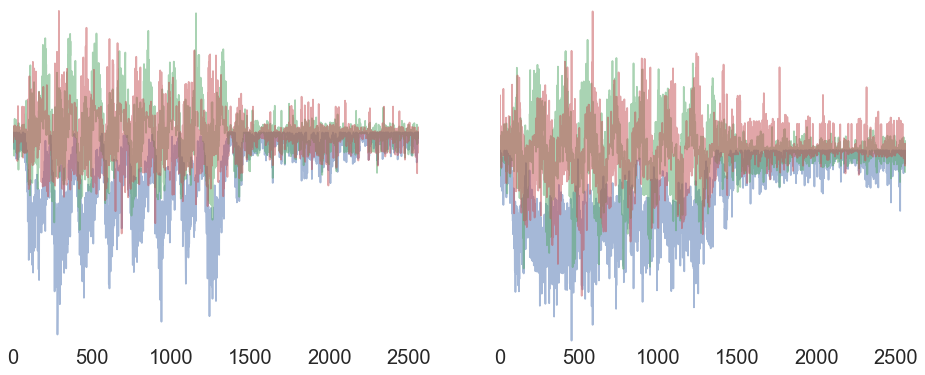

In [152]:
# SVD of y
plt.figure(figsize=(16, 6))
ax = plt.subplot2grid((1, 2), (0, 0))
U,s,V = svd(y[:5,:].mean(axis=0), full_matrices=False)
plt.plot(U.dot(np.diag(s))[:,:3], alpha=0.5);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, 2560]);
print((np.cumsum(s) / s.sum())[100])
ax = plt.subplot2grid((1, 2), (0, 1))
U,s,V = svd(y[5:,:].mean(axis=0), full_matrices=False)
plt.plot(U.dot(np.diag(s))[:,:3], alpha=0.5);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, 2560]);
print((np.cumsum(s) / s.sum())[100])

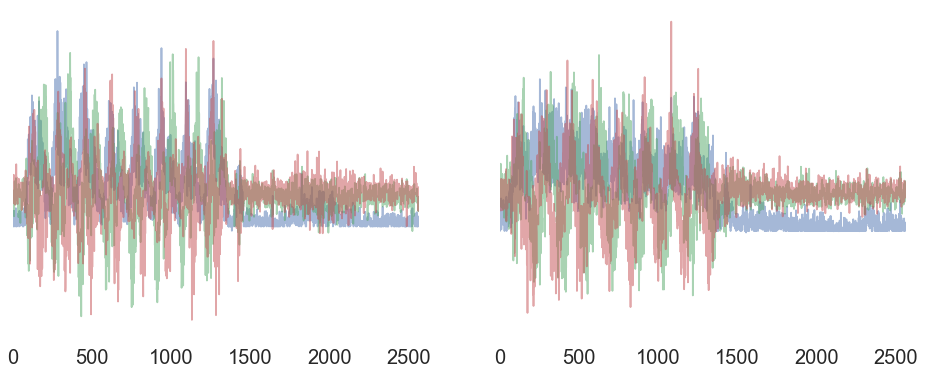

In [159]:
# FA of y
plt.figure(figsize=(16, 6))

ax = plt.subplot2grid((1, 2), (0, 0))
fa = FactorAnalysis(n_components=3)
u = fa.fit_transform(y[:5,:].mean(axis=0))
plt.plot(u, alpha=0.5);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, 2560]);

ax = plt.subplot2grid((1, 2), (0, 1))
fa = FactorAnalysis(n_components=3)
u = fa.fit_transform(y[5:,:].mean(axis=0))
plt.plot(u, alpha=0.5);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, 2560]);

In [181]:
# sequential fitting
np.random.seed(0)
sigma = np.full(9, fill_value=1.0)
omega = np.array([1e-4] * 9)
vLGPfit = vlgp.seqfit(Graf['y'], ['spike'] * Graf['y'].shape[-1], sigma, omega, lag=2, rank=100, 
                       niter=50, tol=1e-5, verbose=True, nadjhess=1, 
                       nhyper=3, learn_sigma=False, learn_omega=True, omega_factor=5)
savemat(os.path.join(outputpath, 'Graf_vLGP_seq'), {'fit': vLGPfit})


Sequential fit

1 latent(s)

Inference starts

[1]
Elapsed Param: 22.10850557871163
omega: [ 0.0001]
Elapsed Post: 0.6165669420734048
LL: -1462648.0443268034
ELBO: -1463131.328167079
sigma: [ 1.]
Elapsed Total: 23.14633505884558

[2]
Elapsed Param: 22.15510560479015
omega: [ 0.0001]
Elapsed Post: 0.627316465601325
LL: -615945.2026218431
ELBO: -615961.9811233863
sigma: [ 1.]
Elapsed Total: 23.189054837916046

[3]
Elapsed Param: 22.01316853892058
omega: [  9.96785564e-05]
Elapsed Post: 0.6245591859333217
LL: -324259.10000859736
ELBO: -324384.70291084645
sigma: [ 1.]
Elapsed Total: 23.609682377893478

[4]
Elapsed Param: 22.068508039228618
omega: [  9.96785564e-05]
Elapsed Post: 0.6183054372668266
LL: -230047.0420377666
ELBO: -230432.51863955485
sigma: [ 1.]
Elapsed Total: 23.098730962257832

[5]
Elapsed Param: 22.124894560780376
omega: [  9.96785564e-05]
Elapsed Post: 0.61714843288064
LL: -202045.9643817547
ELBO: -202487.41008503243
sigma: [ 1.]
Elapsed Total: 23.14453819906339

[6]
Elap

/Users/yuan/variational/mathf.py:70: UserWarning: Not enough rank
  warnings.warn('Not enough rank')


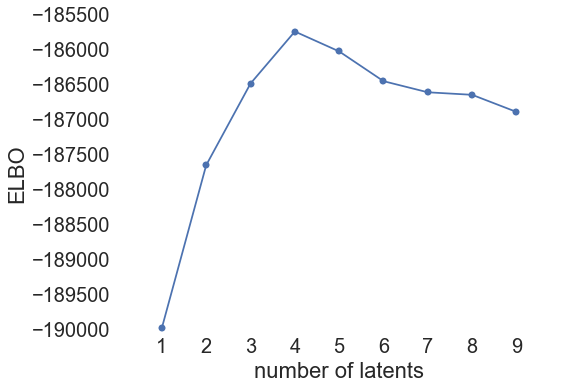

In [236]:
LL = [fit['LL'][-1] for fit in vLGPfit]
ELBO = [fit['ELBO'][-1] for fit in vLGPfit]

plt.figure()
# plt.plot(np.arange(len(LL)) + 1, LL, marker='o', label='LL');
plt.plot(np.arange(len(ELBO)) + 1, ELBO, marker='o', label='ELBO');
plt.xlabel('number of latents');
plt.ylabel('ELBO');
plt.xlim([0, len(ELBO) + 1]);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9]);
sns.despine(left=True, bottom=True, right=True)
# plt.legend(loc='lower right');
plt.tight_layout();
plt.savefig(os.path.join(figurepath, 'graf_elbo.pdf'));

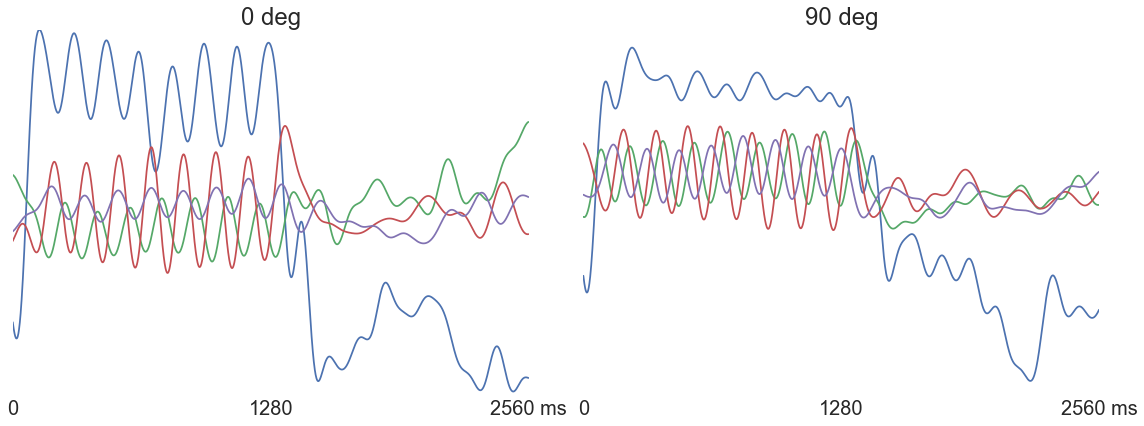

In [271]:
ori0 = bestfit['mu'][:5, :].mean(axis=0)
ori90 = bestfit['mu'][5:, :].mean(axis=0)

plt.figure(figsize=(16, 6))
ax = plt.subplot2grid((1, 2), (0, 0))
ori0, aorth, T = mathf.orthogonalize(ori0, bestfit['a'], True)
plt.plot(ori0[:, :5]);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, ntime]);
plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
plt.title('0 deg');

ax = plt.subplot2grid((1, 2), (0, 1))
ori90, aorth, T = mathf.orthogonalize(ori90, bestfit['a'], True)
plt.plot(ori90[:, :5]);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, ntime]);
plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
plt.title('90 deg');

plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'graf_mean_latent.pdf'));

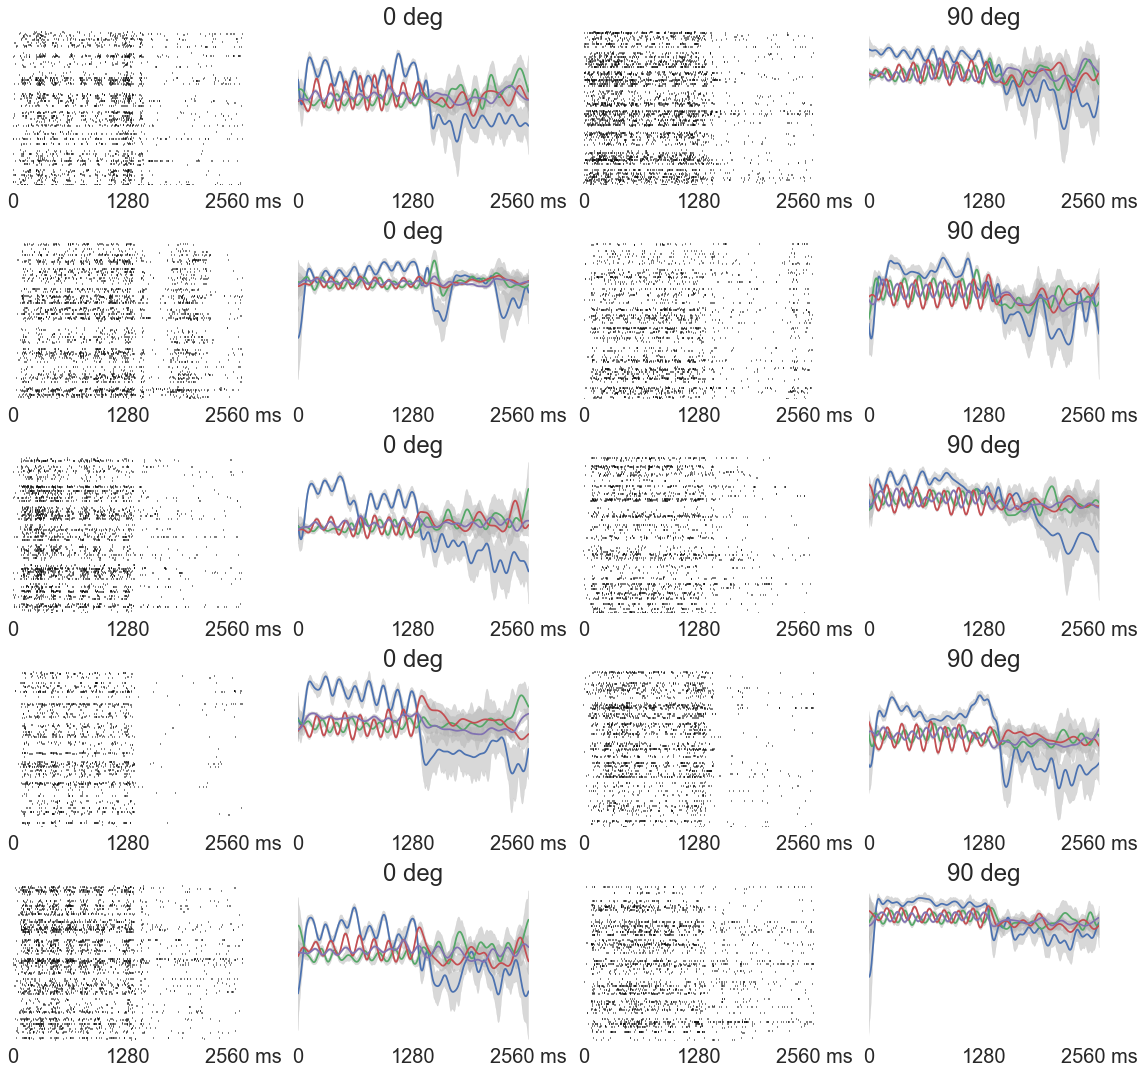

In [216]:
y = Graf['y']
nlatent = 4
plt.figure(figsize=(16, 15))
nsample = 50

for which in range(ntrial):
    ax = plt.subplot2grid((5, 4), (which % 5, 0 + 2 * (which // 5)))
    ntime = 2560
    ntrain = 148
    plt.ylim(0, ntrain);
    for i, n in enumerate(np.random.permutation(np.arange(ntrain))):
        plt.vlines(np.arange(ntime)[y[which, :, n] > 0], i + 0.1, i + 1 - 0.1, color='black', lw=1);
    plt.yticks([]);
    plt.xlim([0, ntime]);
    plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
    ax.set_frame_on(False)
    ax.get_yaxis().set_visible(False);
    ax.invert_yaxis();

    ax = plt.subplot2grid((5, 4), (which % 5, 1 + 2 * (which // 5)))
    xorth, aorth, T = mathf.orthogonalize(bestfit['mu'][which, :], bestfit['a'], True)
    z = np.random.normal(size=(100, nlatent, nsample))
    xs = np.empty((ntime, nlatent, nsample))
    for i in range(nlatent):
        xs[:, i, :] = bestfit['L'][which, i, :].dot(z[:, i, :]) + bestfit['mu'][which, :, i][..., None]
    for j in range(nsample):
        xs[:, :, j] = xs[:, :, j].dot(T)
    xlb = xs.min(axis=2) 
    xub = xs.max(axis=2)
    plt.plot(xorth);
    for i in range(nlatent):
        plt.fill_between(np.arange(2560), xlb[:, i], xub[:, i], color='0.7', alpha=0.5);
    plt.xlim([0, ntime]);
    ax.set_frame_on(False)
    plt.yticks([]);
    plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
    # sns.despine(top=True, right=True, left=True)
    if which < 5:
        plt.title('0 deg');
    else:
        plt.title('90 deg');
plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'graf_spk_latent.pdf'));

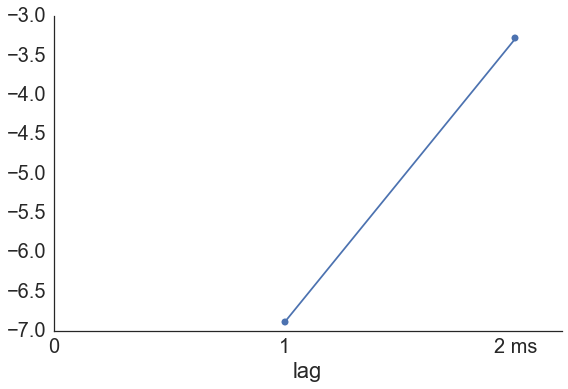

In [231]:
# Autoregression
x = np.arange(bestfit['b'].shape[0])[1:]
# plt.plot(bestfit['b'][1:, :]);
# plt.plot(x, np.median(bestfit['b'], axis=-1)[1:], ls='-', marker='o', label='median');
plt.plot(x, bestfit['b'].mean(axis=-1)[1:], marker='o');
# plt.errorbar(x, bestfit['b'].mean(axis=-1)[1:], yerr=np.std(bestfit['b'], axis=-1)[1:]/np.sqrt(148))
# plt.errorbar(x, y=vLGP4['b'][1:, :].mean(axis=1), yerr=vLGP4['b'][1:, :].std(axis=1)/np.sqrt(vLGP4['b'].shape[-1]), 
#              marker='o', label='Estimate')
# plt.plot(x, vLGP4['b'][1:, :].mean(axis=1), );  
# plt.ylim([-11, 0]);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([0, 1, 2], ['0', '1', '2 ms']);
plt.xlabel('lag');
# Only show ticks on the left and bottom spines
# plt.legend(loc='lower right');
plt.tight_layout()

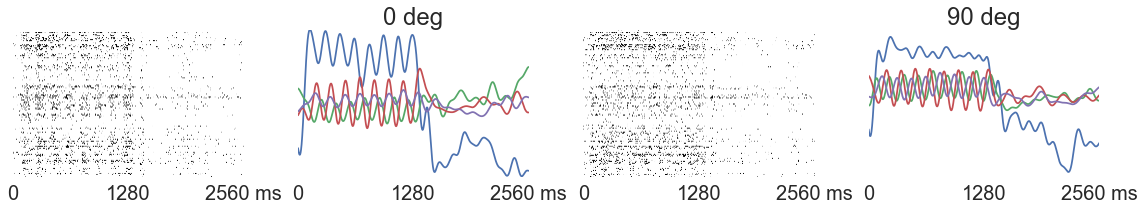

In [270]:
ori0 = bestfit['mu'][:5, :].mean(axis=0)
ori90 = bestfit['mu'][5:, :].mean(axis=0)

plt.figure(figsize=(16, 3))
ax = plt.subplot2grid((1, 4), (0, 0))
ym = y[:5, :].mean(axis=0)
plt.imshow(ym.T, aspect='auto', vmax=0.01);
plt.yticks([]);
plt.xlim([0, ntime]);
plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
ax.set_frame_on(False)

ax = plt.subplot2grid((1, 4), (0, 1))
ori0, aorth, T = mathf.orthogonalize(ori0, bestfit['a'], True)
plt.plot(ori0[:, :5]);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, ntime]);
plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
plt.title('0 deg');

ax = plt.subplot2grid((1, 4), (0, 2))
ym = y[5:, :].mean(axis=0)
plt.imshow(ym.T, aspect='auto', vmax=0.01);
plt.yticks([]);
plt.xlim([0, ntime]);
plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
ax.set_frame_on(False)

ax = plt.subplot2grid((1, 4), (0, 3))
ori90, aorth, T = mathf.orthogonalize(ori90, bestfit['a'], True)
plt.plot(ori90[:, :5]);
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([]);
plt.xlim([0, ntime]);
plt.xticks([0, 1280, 2560], ['0', '1280', '2560 ms']);
plt.title('90 deg');

plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'graf_mean_spk_latent.pdf'));

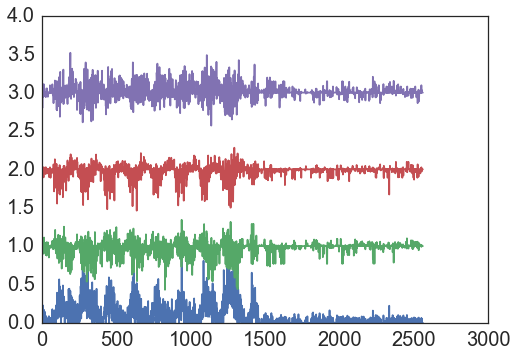

In [278]:
U,s,V = svd(bestfit['a'], full_matrices=False)
yo = y[0, :].dot(V.T)
for i in range(4):
    plt.plot(yo[:, i] +  i);

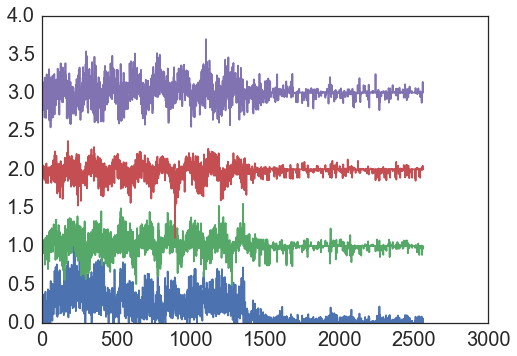

In [279]:
yo = y[5, :].dot(V.T)
for i in range(4):
    plt.plot(yo[:, i] +  i);

In [280]:
for i in range(10):
    yo = y[i, :].dot(V.T)
    print(yo.sum(axis=0))

[ 245.52214208  -46.97766252  -55.605635     23.40010006]
[ 319.30882552  -35.00642939  -60.08311374   -4.49764215]
[ 294.64966187  -44.18959389  -51.84672512   -9.11913288]
[ 167.90115255  -25.82295434  -42.7230938     6.84749563]
[ 318.47262988  -62.62385265  -58.10127526  -12.56117252]
[ 425.20691623   44.6862204   -50.8367049    16.38209241]
[ 242.30562908   44.82773369  -45.10491679   44.1547004 ]
[ 227.38784343   45.07775684  -35.14217948   44.1637497 ]
[ 245.33529461   50.55060179  -40.30368374   46.73121943]
[ 236.71817315   37.03297846  -43.46383518   50.22317438]


In [293]:
Graf5 = h5py.File(os.path.join(samplepath, 'Graf_5.mat'), 'r')

In [294]:
Graf5['y'].shape

(148, 2560, 3600)

In [296]:
Graf5.keys()

KeysViewWithLock(<HDF5 file "Graf_5.mat" (mode r)>)

In [297]:
savemat(os.path.join(outputpath, 'V5.mat'), {'V':V})